In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import minimize
from sklearn.metrics import accuracy_score, f1_score
from functools import partial
from tqdm import tqdm

import torch
import torch.nn as nn

# Данные Mnist

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

https://www.kaggle.com/c/digit-recognizer

In [ ]:
train = pd.read_csv('train.csv')
# test = pd.read_csv('https://s45sas.storage.yandex.net/rdisk/b6856630ccf66400ac28357458fd9ccff62f1b00409d507cf5119969f73245bd/603e9c0c/7iHpXLkj_A4ZUsG7i846E-VlsyigrVfXd45V6UIFuzkpEkY9ErP92J_tIIzSsbdafyn-uYItpj3PvWrkk6EYYA==?uid=331430472&filename=test.csv&disposition=attachment&hash=&limit=0&content_type=text%2Fcsv&owner_uid=331430472&fsize=51118296&hid=67326a408f4ff7fad487a56bff2d5d27&media_type=spreadsheet&tknv=v2&etag=9f3b56df6157e910867d03b3b9d35b9c&rtoken=FUgjbhEyWJxp&force_default=yes&ycrid=na-e9d2e86879ddce60880d78347312f6fe-downloader23e&ts=5bc9358961b00&s=a8cc4b6b9f1dce9a29f4fe553722dd83f2b718f7fc38a3fe670725b2dbc2780e&pb=U2FsdGVkX1-kOt1jFyJKfLIEolM_V1YgWcArYdd0C_8WihITnx2JQbefatLVDBMrArGEh6OdwKb2orGItB10Jah6B7jVSs2KI-mNrxbEbm8')

train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


784 пикселя - изображения 28*28

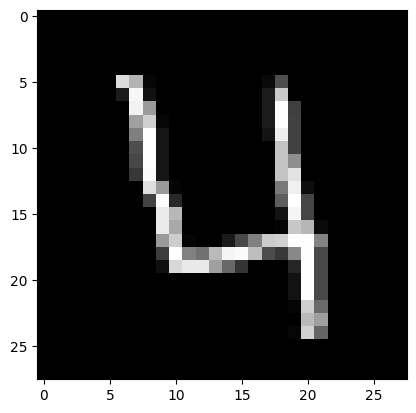

In [ ]:
pixels = np.array(train.iloc[3])
pixels = pixels[1:]
pixels = pixels.reshape((28,28))

plt.imshow(pixels, cmap='gray');

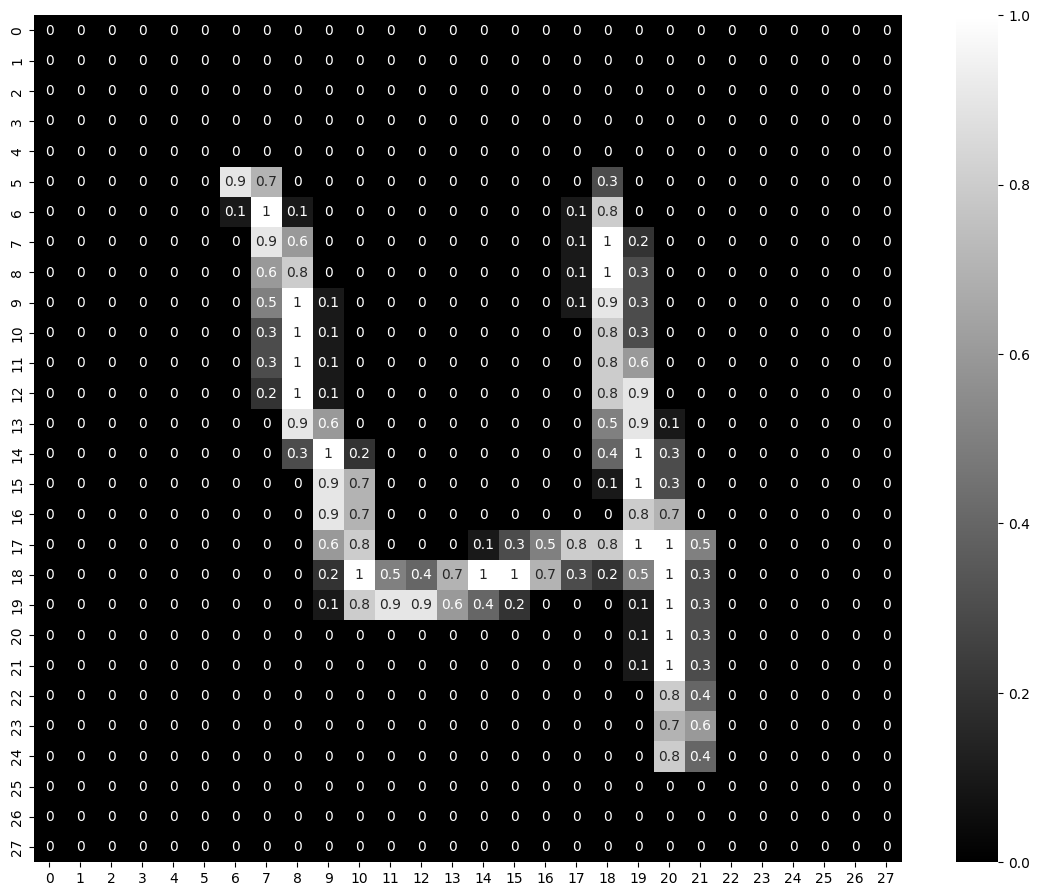

In [ ]:
# отмасштабируем
pixels01 = pixels / 255
plt.figure(figsize=(14,11))

sns.heatmap(np.round(pixels01, 1), annot=True, cmap='gray');

0 - черный 1 - белый 0.5 - оттенки серого

In [ ]:
X_train = np.array(train.drop('label', 1)) / 255
y_train = np.array(train['label'])

# X_test = np.array(test) / 255

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

print('X_train.shape', X_train.shape)
print('y_train.shape', y_train.shape)
print('X_test.shape', X_test.shape)

<ipython-input-8-2d2df8fe9cf3>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train = np.array(train.drop('label', 1)) / 255


X_train.shape (33600, 784)
y_train.shape (33600,)
X_test.shape (8400, 784)


`X_train`, - 42000 картинок по 784 values пикселей
`y_train`, 42000 лейблов

### 1. Биологический нейрон
Нейрон:
![neuron](https://scx1.b-cdn.net/csz/news/800/2018/2-whyareneuron.jpg)
Нейрон имеет:  
1) **входы** (дейндриты). Они могут принимать сигнал от других нейронов
2) **выходы** (аксон). Нейрон обычно имеет один выход. Он передает сигнал другим нейронам
3) Тело

Но какова логика нейрона?

* Нейрон имеет свой собственный **электрический заряд**
* При получении сигнала заряд изменяется на некоторую величину
* Это значение зависит от того, какой дендрит принял сигнал
* Некоторые дендриты повышают заряд *(возбуждающий дендрит)*, а некоторые понижают его *(тормозной дендрит)*
* Когда заряд его достаточно велик, происходит **разряд**: нейрон передает сигнал другим нейронам через свой Аксон (выход)

### 2. Математический нейрон
Теперь нам нужен искусственный нейрон:
![](https://cdn-images-1.medium.com/freeze/max/1000/1*tMuOsWWRX3fR84xoSeJcAw.png?q=20)
Идея та же самая. Нейрон имеет:
* Несколько входов $x_1, x_2, ..., x_{784}$. Это будут наши **значения пикселей**
* Веса $w_1, w_2, ..., w_{784}$ для каждого входного сигнала. Положительные веса соответствуют *возбуждающим дендритам*, а отрицательные - *тормозным дендритам*
* Операция суммирования: $S = x_1w_1 + x_2w_2 + ... + x_Nw_N$. Или $S=\vec{x} \cdot \vec{w}$.
* Функция активации. Он сопоставит $S$ с числом от 0 до 1: $\sigma (S) \in [0,1]$. Это называется сигмовидной:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/400px-Logistic-curve.svg.png)
$$\sigma(x) = \frac{e^x}{1 + e^x}$$

In [ ]:
# создадим случайный нейрон
neuron_r = np.random.normal(size=(784,))
neuron_r /= np.sqrt(784) # меньше дисперчсия

def sigmoid(x):
    ex = np.exp(x)
    return ex / (1 + ex)

In [ ]:
# Давайте применим случайный нейрон к какому-нибудь изображению:
x = X_train[0]
output = sigmoid(x @ neuron_r)
print(output)

0.4189711476175169


Что мы сделали?
Мы создали нейрон, который берет вектор и выводит одно число, и это число не имеет смысла.

Нам нужно тренировать наш нейрон!
Давайте дадим ему более простую задачу: **вывод 1, когда изображение является цифрой 1, и вывод 0 в противном случае**.

In [ ]:
# создаем треин
y_train1 = (y_train == 1).astype(int)

print(y_train1[:20])

[0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0]


Как делать прогнозы для всего набора данных? Давайте снова воспользуемся матричным умножением

In [ ]:
predictions = sigmoid(X_train @ neuron_r)
print('Predictions:', predictions[:10])
print('Truth:', y_train1[:10])

Predictions: [0.41897115 0.51115502 0.4795959  0.48232805 0.37583426 0.45239821
 0.34131395 0.44489209 0.43829536 0.46983403]
Truth: [0 0 0 0 0 1 0 1 0 0]


Теперь мы хотим **тренировать** наш нейрон. Это означает, что мы хотим сделать прогнозы ближе к истинным значениям.

Для этого мы будем использовать [перекрестную энтропию](https://en.wikipedia.org/wiki/Cross_entropy) - функция, которая показывает нам, насколько близки два распределения.

H(X) = – sum x in X P(x) * log(P(x))

In [ ]:
def cross_entropy(y_true, y_pred):
    out1 = y_true * np.log(y_pred + 1e-12) # small number for numerical stability
    out2 = (1 - y_true) * np.log(1 - y_pred + 1e-12)
    return -(out1 + out2).mean()

print(cross_entropy(y_train1, predictions))

0.6102623729447315


Итак, это перекрестная энтропия. Мы хотим, чтобы он был меньше.

Давайте создадим нейрон, который минимизирует перекрестную энтропию!

functools.partial(func, *args, **keywords) - возвращает partial-объект (по сути, функцию), который при вызове вызывается как функция func, но дополнительно передают туда позиционные аргументы args, и именованные аргументы kwargs. Если другие аргументы передаются при вызове функции, то позиционные добавляются в конец, а именованные расширяют и перезаписывают.

In [ ]:
%%time

def _loss(neuron, X, y):
    predictions = sigmoid(X @ neuron)
    error = cross_entropy(y, predictions)
    return error

# ограничемся 500 примерами
error = partial(_loss, X=X_train[:500], y=y_train1[:500])
# минимизируем ошибку для нашего нейрона с помощью scipy
neuron_1 = minimize(error, x0=neuron_r).x

CPU times: user 8.64 s, sys: 2.63 s, total: 11.3 s
Wall time: 5.87 s


In [ ]:
y_test1 = (y_test == 1).astype(int)

In [ ]:
predictions = sigmoid(X_test @ neuron_1)
print('Error:', cross_entropy(y_test1, predictions))

Error: 0.27688814829504327


In [ ]:
# создаем треин
y_test1 = (y_test == 1).astype(int)

print(y_test[:20])

print('Accuracy:', accuracy_score(y_test1, predictions > 0.5))
print('F1:', f1_score(y_test1, predictions > 0.5))

[6 2 7 4 9 1 7 2 0 8 1 6 2 6 3 3 4 4 1 4]
Accuracy: 0.9805952380952381
F1: 0.9121293800539084


Смотрим на метрики

In [ ]:
print('Accuracy:', accuracy_score(y_test1, predictions > 0.5))
print('F1:', f1_score(y_test1, predictions > 0.5))

Accuracy: 0.9805952380952381
F1: 0.9121293800539084


Визуализируем нейрон

In [ ]:
# массив весов для одного пикселя
neuron_1

array([ 3.29781066e-02,  5.30945083e-02, -1.21518013e-02, -4.25804584e-02,
        2.54189701e-02,  3.28922784e-02,  3.85407602e-02,  3.94762158e-02,
        4.92917781e-03,  2.51096760e-02,  2.19549528e-02,  4.29655072e-02,
        4.84067350e-03,  6.88981218e-02, -6.35079473e-02,  4.72025946e-02,
        4.57066342e-02, -2.94031892e-02,  2.61641905e-02,  5.31757187e-02,
        2.34126331e-02, -7.09975311e-02,  1.99256979e-02, -8.52691999e-03,
        5.99843678e-02,  1.70321488e-02, -5.34413014e-02,  2.87529839e-02,
       -1.59608212e-03,  1.31050024e-02,  2.72242738e-02,  1.52101496e-02,
        1.35600175e-03,  1.07975203e-02,  1.66415098e-02,  8.66121429e-04,
       -3.89944638e-03, -3.62365646e-02, -7.05385073e-02, -1.13637753e-02,
        2.11797817e-02, -8.10143873e-03,  7.05243577e-02, -2.80611964e-02,
       -2.78458112e-02, -7.00615286e-02, -2.59292508e-02, -1.62944923e-02,
       -1.05163111e-02,  1.78023758e-02,  4.54431356e-04, -2.50758566e-02,
       -1.13371925e-02,  

<Axes: >

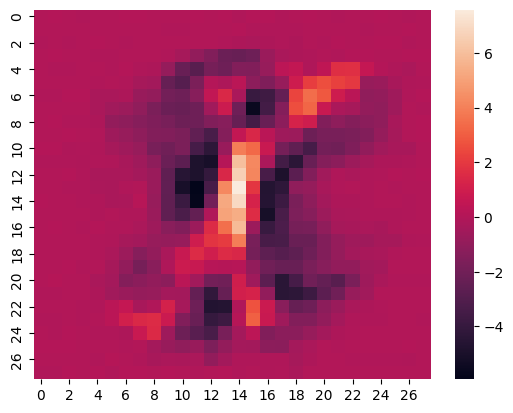

In [ ]:
# let's print it
neuron_image = neuron_1.reshape(28, 28)
sns.heatmap(neuron_image)

Здесь мы видим веса каждого пикселя. Положительный означает, что пиксель оказывает положительное влияние на предсказание "1". Это немного похоже на тень цифры "1".

## Обучим 10 нейронов

In [ ]:
%%time

neurons = []

for digit in range(10):
    print('Training neuron', digit)
    y = y_train == digit
    error = partial(_loss, X=X_train[:100], y=y[:100])
    neuron = minimize(error, x0=neuron_r).x
    neurons.append(neuron)

Training neuron 0
Training neuron 1
Training neuron 2
Training neuron 3
Training neuron 4
Training neuron 5
Training neuron 6
Training neuron 7
Training neuron 8
Training neuron 9
CPU times: user 39.8 s, sys: 17.1 s, total: 56.9 s
Wall time: 33.2 s


Визуализируем их предсказания

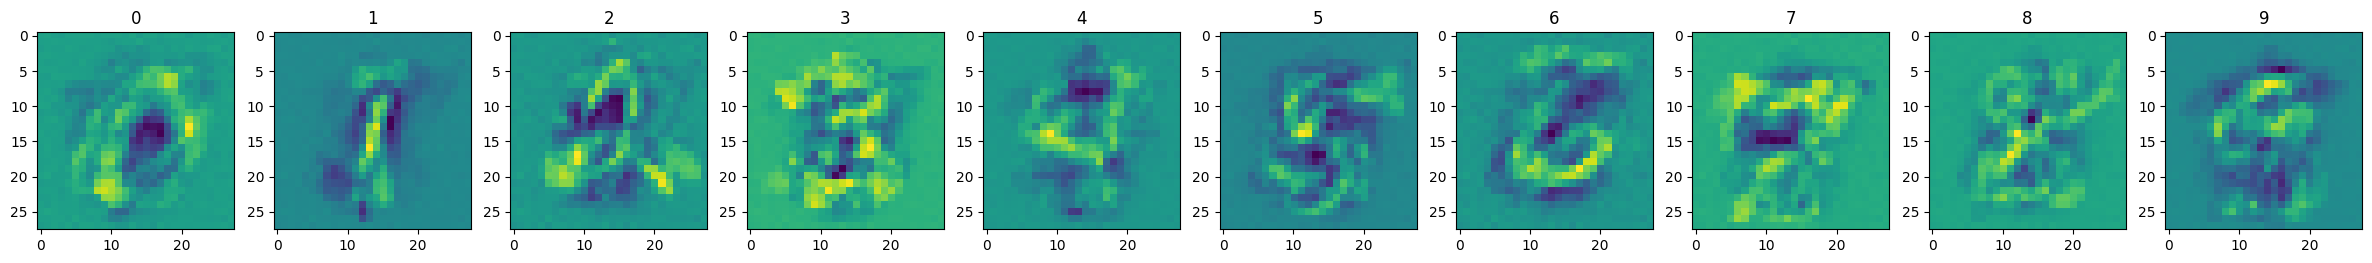

In [ ]:
fig, axes = plt.subplots(1, 10, figsize=(30,30))

for i in range(10):
    axes[i].set_title(i)
    neuron_img = neurons[i].reshape(28, 28)
    axes[i].imshow(neuron_img)

Похоже на цифры!

Теперь мы можем сделать классификацию, используя эти 10 нейронов:

In [ ]:
digit_probabilities = sigmoid(X_test @ np.array(neurons).T)
print('digit_probabilities.shape:', digit_probabilities.shape)
# Теперь у нас есть вероятности для каждого изображения для каждой цифры

# Возьмем в качестве прогноза максимум
predictions = np.argmax(digit_probabilities, axis=1)
print('predictions.shape:', predictions.shape)
print('\nTrain f1:', f1_score(y_test, predictions, average='weighted'))

digit_probabilities.shape: (8400, 10)
predictions.shape: (8400,)

Train f1: 0.7183876504723032


## 1. Нейросеть?
![](https://i.imgflip.com/3gavrz.jpg)
В нейронной сети нейроны соединены в сеть.

Реальная сеть выглядит так:
![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/99/Neural_network_example.svg/360px-Neural_network_example.svg.png)

Каждый круг на этом изображении-это нейрон, а каждая стрелка-взвешенная связь.

# 2. Pytorch

![](https://github.com/pytorch/pytorch/raw/master/docs/source/_static/img/pytorch-logo-dark.png)

Источник:

* https://pytorch.org/docs/stable/index.html
* https://www.kaggle.com/kanncaa1/pytorch-tutorial-for-deep-learning-lovers
* https://habr.com/ru/post/334380/

PyTorch — современная библиотека глубокого обучения, развивающаяся под крылом Facebook. PyTorch является аналогом фреймворка Torch7 для языка Python.

Для начала разберёмся, что же вообще такое фреймворк глубокого обучения. Под глубоким обучением как правило понимают обучение функции, представляющей собой композицию множества нелинейных преобразований. Такая сложная функция ещё называется потоком или графом вычислений. Фреймворк глубокого обучения должен уметь делать всего три вещи:


* Определять граф вычислений
* Дифференцировать граф вычислений
* Вычислять его

Чем быстрее ты умеешь вычислять свою функцию и чем гибче твои возможности для её определения, тем лучше. Сейчас, когда каждый фреймворк умеет использовать всю мощь видеокарт, первый критерий перестал играть значительную роль. Что нас действительно интересует, так это доступные возможности для определения потока вычислений. Все фреймворки здесь можно разделить на три крупные категории.

* **Фиксированные модули** Такой подход можно сравнить с конструктором Lego: пользователь комбинирует заранее определённые блоки в граф вычислений и запускает его. Прямой и обратный проходы уже зашиты в каждом таком блоке. Определение новых блоков гораздо сложнее использования готовых и требует совершенно иных знаний и умений. Расширяемость близка к нулю, однако если ваши идеи полностью реализуются в таком фреймворке, скорость разработки максимальна. Со скоростью работы, благодаря высокой оптимизированности заранее написанного кода, также не возникает проблем. Типичные представители: Caffe, Caffe2, CNTK, Kaldi, DL4J, Keras (как интерфейс).


* **Статический граф вычислений** Эти фреймворки уже можно сравнить с полимерной глиной: на этапе описания возможно создать граф вычислений произвольного размера и сложности, однако после запекания (компиляции) он станет твёрдым и монолитным. Доступными останутся всего два действия: запустить граф в прямом или обратном направлениях. Все такие фреймворки используют декларативный стиль программирования и напоминают функциональный язык или математическую нотацию. С одной стороны, этот подход комбинирует гибкость на этапе разработки и скорость в момент исполнения. С другой стороны, как и в функциональных языках, отладка становится настоящей головной болью, а модели, выходящие за рамки парадигмы, требуют либо титанических усилий, либо здоровенных костылей для реализации. Представители: Theano, TensorFlow, MXNet.

* **Динамический граф вычислений** Представьте теперь, что вы можете перестраивать статический граф перед каждым его запуском. Примерно это и происходит в данном классе фреймворков. Только графа как отдельной сущности здесь нет. Он, как и в императивных языках программирования, слишком сложен для явного построения и существует лишь в в момент исполнения. Точнее сказать, граф строится динамически каждый раз при прямом проходе для того, чтобы затем иметь возможность сделать проход обратный. Подобный подход даёт максимальную гибкость и расширяемость, позволяет использовать в вычислениях все возможности используемого языка программирования и не ограничивает пользователя вообще ничем. К этому классу фреймворков как раз и относятся Torch и PyTorch.


Прямой проход написать на numpy тривиально, а формулу обновления весов можно посчитать на листочке. Выглядеть такой первый код мог так:

In [ ]:
import numpy as np

def MyNetworkForward(weights, bias, x):
    h1 = weights @ x + bias
    a1 = np.tanh(h1)
    return a1

y = MyNetworkForward(weights, bias, x)
loss = np.mean((y - y_hat) ** 2)

Со временем архитектуры сетей становятся сложнее и глубже и возможностей NumPy, карандаша и бумаги уже перестаёт хватать. Невольно начинаешь задумываться о двух вещах:

* Вот бы уметь запускать мои вычисления а видеокарте
* Вот бы все градиенты считались за меня

При этом не хочется менять привычный подход, хочется просто написать:



In [ ]:
import numpy as np

def MyNetworkForward(weights, bias, x):
    h1 = weights @ x + bias
    a1 = np.tanh(h1)

    return a1

weights.cuda()
bias.cuda()
x.cuda()

y = MyNetworkForward(weights, bias, x)
loss = np.mean((y - y_hat) ** 2)

loss.magically_calculate_backward_pass()

PyTorch ровно это и делает! Вот совершенно правильный код:

In [ ]:
import torch

def MyNetworkForward(weights, bias, x):
    h1 = weights @ x + bias
    a1 = torch.tanh(h1)

    return a1

weights = weights.cuda()
bias = bias.cuda()
x = x.cuda()

y = MyNetworkForward(weights, bias, x)
loss = torch.mean((y - y_hat) ** 2)

loss.backward()

Остаётся лишь применить уже посчитанные обновления параметров.

В Theano и TensorFlow мы описываем граф на декларативном DSL, который затем компилируется в некоторый внутренний байткод и исполняется в монолитном ядре, написанном на C++, или же компилируется в код на C и исполняется как отдельный бинарный объект. Если в момент компиляции нам известен весь граф целиком, его с лёгкостью можно продифференцировать, например символьно. Однако так ли необходима стадия компиляции?


Оказывается, нет. Ничто не мешает нам строить граф динамически одновременно с его вычислением! А благодаря технике автоматического дифференцирования (automatic differentiation, AD) мы можем взять и продифференцировать граф в любой момент времени в любом его состоянии. В компиляции графа нет совершенно никакой реальной необходимости. Что касается скорости, вызов лёгких нативных процедур из интерпретатора Python оказывается не медленнее, чем исполнение скомпилированного кода.

Начнём с NumPy части. Тензорные вычисления — основа PyTorch, каркас, вокруг которого наращивается вся остальная функциональность. К сожалению, нельзя сказать, что мощь и выразительность библиотеки в данном аспекте совпадает с таковой у NumPy. Во всём, что касается работы с тензорами, PyTorch руководствуется принципом максимальной простоты и прозрачности, предоставляя тонкую обёртку над вызовами BLAS.

## Тензоры

Тип данных, хранимых тензором, отражается в имени его конструктора. Конструктор без параметров вернёт специальное значение — тензор без размерности, который нельзя использовать ни в каких операциях.

In [ ]:
torch.FloatTensor()

tensor([])

In [ ]:
torch.HalfTensor      # 16 бит, с плавающей точкой
torch.FloatTensor     # 32 бита,  с плавающей точкой
torch.DoubleTensor    # 64 бита, с плавающей точкой

torch.ShortTensor     # 16 бит, целочисленный, знаковый
torch.IntTensor       # 32 бита, целочисленный, знаковый
torch.LongTensor      # 64 бита, целочисленный, знаковый

torch.CharTensor      # 8 бит, целочисленный, знаковый
torch.ByteTensor      # 8 бит, целочисленный, беззнаковый

torch.ByteTensor

In [ ]:
a = torch.IntTensor([1])
a.byte()

tensor([1], dtype=torch.uint8)

In [ ]:
a.float()

tensor([1.])

x.type_as(y) вернёт тензор значений из x того же типа, что и y.

Если передать конструктору тензора в качестве параметра список, будет построен тензор соответствующей размерности и с соответствующими данными.

In [ ]:
a = torch.IntTensor([[1, 2], [3, 4]])
a

tensor([[1, 2],
        [3, 4]], dtype=torch.int32)

Неправильно сформированные списки не допускаются так же, как и в NumPy

In [ ]:
torch.IntTensor([[1, 2], [3]])

ValueError: ignored

Другой возможный набор аргументов конструктора тензора — его размер. Количество аргументов при этом определяет размерность.



In [ ]:
torch.FloatTensor(1)

tensor([7.3902e-25])

Построенный таким методом тензор содержит мусор — случайные значения.

In [ ]:
torch.FloatTensor(3, 3)

tensor([[9.2930e+14, 4.5766e-41, 7.3902e-25],
        [0.0000e+00, 4.4842e-44, 0.0000e+00],
        [8.9683e-44, 0.0000e+00, 6.6448e-25]])

## Индексирование

Поддерживается стандартное индексирование Python: обращение по индексу и срезы.

In [ ]:
a = torch.IntTensor([[1, 2, 3], [4, 5, 6]])
a

tensor([[1, 2, 3],
        [4, 5, 6]], dtype=torch.int32)

In [ ]:
a[0]

tensor([1, 2, 3], dtype=torch.int32)

In [ ]:
a[0][1]

tensor(2, dtype=torch.int32)

In [ ]:
a[1, 2]

tensor(6, dtype=torch.int32)

In [ ]:
a[:, 0]

tensor([1, 4], dtype=torch.int32)

In [ ]:
a[0, 1:3]

tensor([2, 3], dtype=torch.int32)


Также в качестве индексов могут выступать другие тензоры. Однако, возможности здесь всего две:


* Одномерный torch.LongTensor, индексирующий по нулевому измерению (по элементам в случае векторов и по строкам в случае матриц);
* Соразмерный torch.ByteTensor, содержащий только значения 0 или 1, служащий маской.

In [ ]:
a = torch.ByteTensor(3,4).random_()
a

tensor([[162, 109, 115,  73],
        [135, 255, 213,  84],
        [164,  10,  57,  78]], dtype=torch.uint8)

In [ ]:
a[torch.LongTensor([0, 2])]

tensor([[162, 109, 115,  73],
        [164,  10,  57,  78]], dtype=torch.uint8)

In [ ]:
a[a > 128]

tensor([162, 135, 255, 213, 164], dtype=torch.uint8)

Всю доступную информацию о тензоре помогут узнать функции x.dim(), x.size() и x.type(), а x.data_ptr() укажет на место в памяти, где находятся данные.

In [ ]:
a = torch.Tensor(3, 3)
a.dim()

2

In [ ]:
a.size()

torch.Size([3, 3])

In [ ]:
a.type()

'torch.FloatTensor'

In [ ]:
a.data_ptr()

392476608

## Операции над тензорами

Соглашение о именовании в PyTorch гласит, что любая функция вида xxx возвращает новый тензор, т.е. является immutable функцией. В противоположность ей функция вида xxx_ изменяет изначальный тензор, т.е. является mutable функцией. Последние ещё носят название inplace функций.

Почти для любой immutable функции в PyTorch существует её менее чистый собрат. Однако бывает и так, что функция существует лишь в каком-то одном варианте. По понятным причинам, функции, изменяющие размер тензора всегда являются immutable.

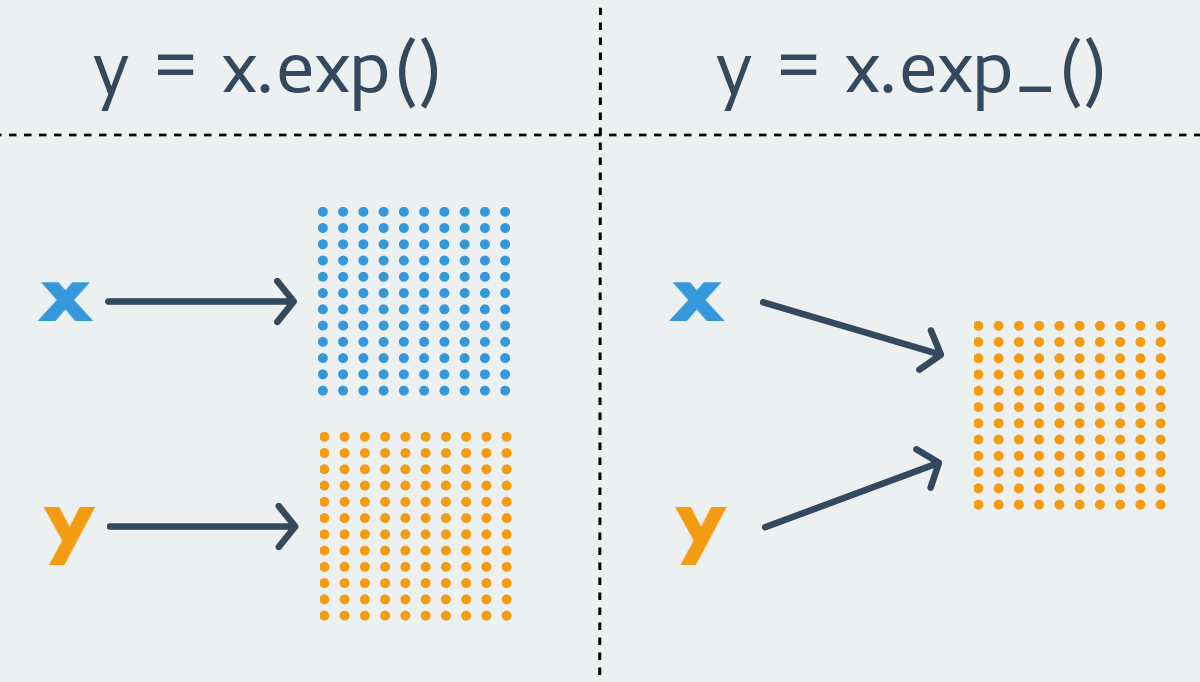

### Функции инициализации

ак правило, они используются для инициализации при создании новых тензоров заданного размера

In [ ]:
x = torch.FloatTensor(3, 4) # мусор
x.zero_()

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

Так как mutable функции возвращают ссылку на объект, удобнее записывать объявление и инициализацию в одну строчку.

In [ ]:
x = torch.FloatTensor(3, 4).zero_()

* x.zero_()

    Инициализирует тензор нулями. Не имеет immutable варианта.
* x.fill_(n)

    Заполняет тензор константой n. Аналогично не имеет immutable варианта.
* x.random_(from, to)

    Заполняет тензор сэмплами из дискретного (даже для вещественнозначных тензоров) равномерного распределения.
    
    Если from и to не указаны, то они приравниваются нижней и верхней границам используемого типа данных соответственно.
* x.uniform_(from=0, to=1)

    Тоже равномерное распределение, но уже непрерывное и с более привычными границами по-умолчанию. Доступно только для вещественнозначных тензоров.
* x.normal_(mean=0, std=1)

    Нормальное распределение. Доступно только для вещественнозначных тензоров.
* x.bernoulli_(p=0.5)
    
    Распределение Бернулли. В качестве p может использоваться скаляр либо тензор той же размерности со значениями 0 <= p <= 1. Важно отличать эту версию от immutable варианта, так как он имеет другую семантику. Вызов y = x.bernoulli() эквивалентен y.bernoulli_(x), т.е. x здесь сам используется как тензор параметров распределения.
* torch.eye(n, m)

    Создаёт единичную матрицу n x m. Здесь по неясным для меня причинам не существует уже inplace варианта.

Доступны также экспоненциальное и геометрическое распределения, распределение Коши, логарифм нормального распределения и ещё несколько более сложных вариантов инициализации тензора. Не стесняйтесь смотреть в документацию!

### Математические операции

Самая часто используемая группа. Если операция здесь не изменяет размер и тип тензора, то у неё существует inplace вариант.


* Сложение.
    ```
    z = x.add(y)
    z = torch.add(x, y)
    x.add_(y)
    ```

* Вычитаение.
    ```
    z = x.sub(y)
    z = torch.sub(x, y)
    x.sub_(y)
    ```
* Умножение.
    ```
    z = x.mul(y)
    z = torch.mul(x, y)
    x.mul_(y)
    ```
* Деление. Для целочисленных типов деление целочисленное.
    ```
    z = x.div(y)
    z = torch.div(x, y)
    x.div_(y)
    ```
* Экспонента.
    ```
    z = x.exp()
    z = torch.exp(x)
    x.exp_()
    ```
* Натуральный логарифм.
```
z = x.log()
z = torch.log(x)
x.log_()
```
* Натуральный логарифм от x + 1. Функция оптимизирована по точности вычислений для малых x.
```
z = x.log1p()
z = torch.log1p(x)
x.log1p_()
```

* Модуль.
```
z = x.abs()
z = torch.abs(x)
x.abs_()
```

Естественно, присутствуют все основные тригонометрические операции в том виде, в каком вы ожидаете их увидеть. Перейдём теперь к менее тривиальным функциям.

* Транспонирование. Несмотря на то, что размер тензора меняется, существует inplace вариант функции, так как размер данных в памяти остаётся тем же.
```
z = x.t()
z = torch.t(x)
x.t_()
```
* Матричное умножение.
```
z = x.mm(y)
z = torch.mm(x, y)
```
* Умножение матрицы на вектор.
```
z = x.mv(v)
z = torch.mv(x, v)
```
* Скалярное умножение тензоров.
```
z = x.dot(y)
z = torch.dot(x, y)
```
* Перемножает матрицы целыми батчами.
```
bz = bx.bmm(by)
bz = torch.bmm(bx, by)
```



In [ ]:
bx = torch.randn(10, 3, 4)
by = torch.randn(10, 4, 5)
bz = bx.bmm(by)
bz.size()

torch.Size([10, 3, 5])

Существуют также полные аналоги BLAS функций со сложными сигнатурами, такие как addbmm, addmm, addmv, addr, baddbmm, btrifact, btrisolve, eig, gels и множество других.

Операции редукции похожи друг на друга по сигнатуре. Почти все они своим последним необязательным аргументом принимают dim — размерность, по которой редукция проводится. Если аргумент не задан, операция действует на весь тензор целиком.

* Выборочное среднее. Определена только для вещественнозначных тензоров.
```
s = x.mean(dim)
s = torch.mean(x, dim)
```
* Выборочное стандартное отклонение. Определена только для вещественнозначных тензоров.
```
s = x.std(dim)
s = torch.std(x, dim)
```

* Выборочная дисперсия. Определена только для вещественнозначных тензоров.
```
s = x.var(dim)
s = torch.var(x, dim)
```

* Медиана.
```
s = x.median(dim)
s = torch.median(x, dim)
```

* Сумма.
```
s = x.sum(dim)
s = torch.sum(x, dim)
```

* Произведение.
```
s = x.prod(dim)
s = torch.prod(x, dim)
```

* Максимум.
```
s = x.max(dim)
s = torch.max(x, dim)
```

* Минимум.
```
s = x.min(dim)
s = torch.min(x, dim)
```

Всевозможные операции сравнения (eq, ne, gt, lt, ge, le) также определены и возвращают в качестве результата своей работы маску типа ByteTensor .


Операторы +, +=, -, -=, *, *=, /, /=, @ работают ровно так, как вы и ожидаете, вызывая соответствующие описанные выше функции. Однако из-за сложности и не полной очевидности API, я не рекомендую пользоваться операторами, а использовать вместо этого явный вызов нужных функций. По крайней мере не стоит смешивать два стиля, это позволит избежать ошибок навроде x += x.mul_(2).


У PyTorch в запасе ещё много интересных функций вроде сортировки или поэлементного применения функции, но все они крайне редко используются в глубоком обучении. Если же вы захотите использовать PyTorch в качестве библиотеки тензорных вычислений, не забудьте перед этим заглянуть в документацию.

Функции torch.from_numpy(n) и x.numpy() могут быть использованы, чтобы конвертировать тензоры одной библиотеки в тензоры другой. Тензоры при этом используют одно и то же внутренне хранилище, копирования данных не происходит.

In [ ]:
a = np.random.rand(3, 3)
a

array([[0.10030093, 0.53265932, 0.7851555 ],
       [0.63061923, 0.31837499, 0.33043239],
       [0.6458425 , 0.99449692, 0.94547331]])

In [ ]:
b = torch.from_numpy(a)
b

tensor([[0.0313, 0.3144, 0.8901],
        [0.3102, 0.9876, 0.0879],
        [0.0374, 0.7851, 0.6320]], dtype=torch.float64)

In [ ]:
b.sub_(b)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], dtype=torch.float64)

Реализовать прямой проход для произвольной функции на PyTorch ничуть не сложнее, чем сделать это с помощью NumPy. Нужно лишь свыкнуться с inplace операциями и запомнить имена основных функций. Для примера, линейный слой с функцией активации softmax:

In [ ]:
def LinearSoftmax(x, w, b):
    s = x.mm(w).add_(b)
    s.exp_()
    s.div_(s.sum(1))

    return s

## CUDA

Здесь всё просто: тензоры могут жить либо "на процессоре", либо "на видеокарте". Правда, они весьма привередливы и живут только на видеокартах от Nvidia, причём не на самых старых. По-умолчанию тензор создаётся на CPU.

In [ ]:
x = torch.FloatTensor(1024, 1024).uniform_()

In [ ]:
x.is_cuda

False

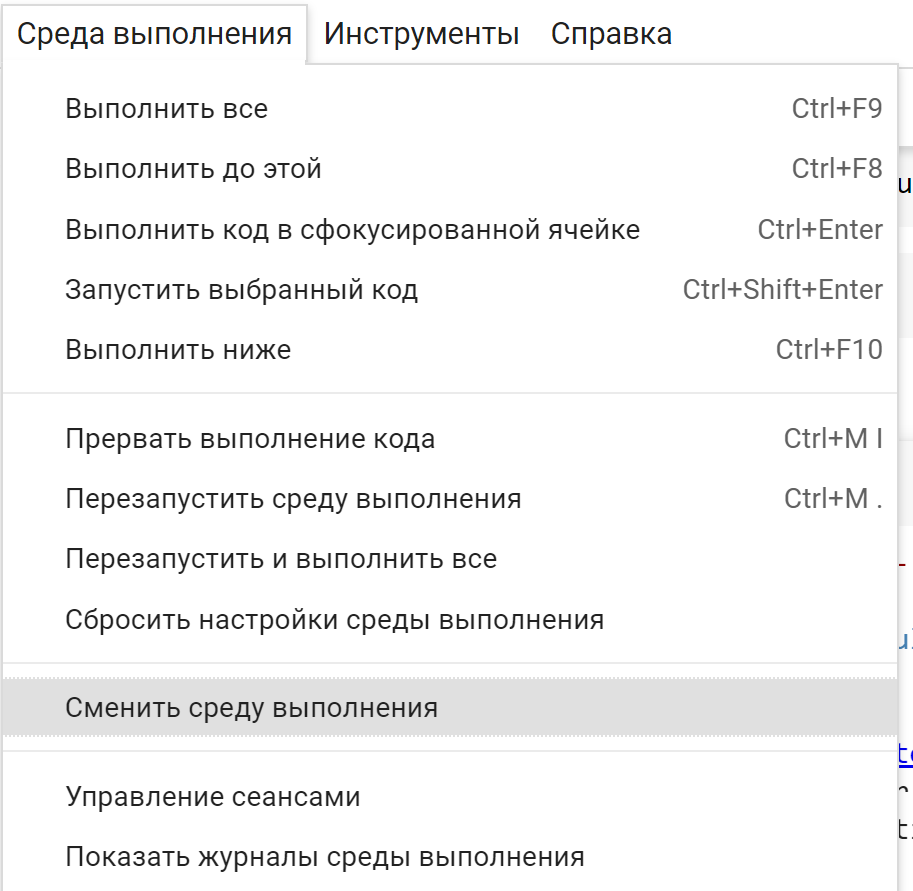

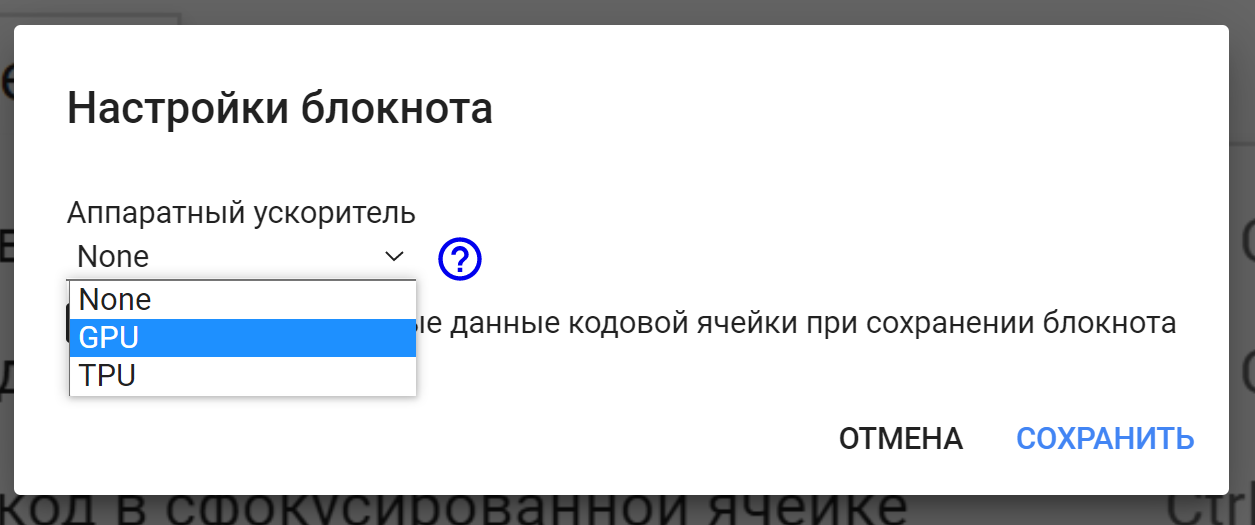

In [ ]:
x = x.cuda()

In [ ]:
x.is_cuda # На самом деле x.cuda() возвращает копию тензора, а не перемещает его.

True

Когда исчезнут все ссылки на тензор, находящийся в видеопамяти, PyTorch не удалит его моментально. Вместо этого при следующем выделении он либо переиспользует этот участок видеопамяти, либо очистит её.

Если у вас несколько видеокарт, функция x.cuda(device=None) с радостью примет в качестве опционального аргумента номер видеокарты, куда стоит положить тензор, а функция x.get_device() покажет на каком устройстве тензор x находится. Функция x.cpu() скопирует тензор из видеокарты "на процессор".

Естественно, мы не можем производить никакие операции с тензорами, находящимеся на разных устройствах.

Вот, например, как можно перемножить два тензора на видеокарте и вернуть результат обратно в оперативную память:

In [2]:
%time
import torch
a = torch.FloatTensor(10000, 10000).uniform_()
b = torch.FloatTensor(10000, 10000).uniform_()
# c = a.cuda().mul_(b.cuda()).cpu()

CPU times: total: 0 ns
Wall time: 0 ns


In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device
# a.to(device)
# a.cpu()

device(type='cpu')

И всё это доступно прямо из интерпретатора! Представьте аналогичный код на TensorFlow, где вам придётся создать граф, сессию, скомпилировать граф, инициализировать переменные и запустить граф на сессии. С помощью PyTorch я могу даже отсортировать тензор на видеокарте одной строчкой кода!


Тензоры можно не только копировать на видеокарту, но и создавать их прямо на ней. Для этого используется модуль torch.cuda.

Контекстный менеджер torch.cuda.device(device) позволяет создавать все определённые внутри него тензоры на указанной видеокарте. Результаты операций над тензорами с других устройств останутся там, где и должны быть. Переданное в x.cuda(device=None) значение приоритетнее, чем то, которое диктует контекстный менеджер.



In [ ]:
x = torch.cuda.FloatTensor(1)
y = torch.FloatTensor(1).cuda()

with torch.cuda.device(0):
    a = torch.cuda.FloatTensor(1)
    b = torch.FloatTensor(1).cuda()
    c = a + b
    z = x + y
    d = torch.FloatTensor(1).cuda(0)

    print(d)

tensor([9.2929e+14], device='cuda:0')


## Автоматическое дифференцирование

Механизм автоматического дифференцирования, заключённый в модуле torch.autograd, является хоть и не главным, но, без сомнения, важнейшим компонентом библиотеки, без которого та потеряла бы всякий смысл.


Вычисление градиента функции в заданной точке — центральная операция методов оптимизации, на которых, в свою очередь, держится всё глубокое обучение. Обучение здесь — синоним оптимизации. Существует три основных способа вычислить градиент функции в точке:

* Численно методом конечных разностей;
* Символьно;
* Использовать технику автоматического дифференцирования.

Первым методом пользуются лишь для проверки результатов из-за его низкой точности. Символьное вычисление производной эквивалентно тому, что вы делаете вручную, используя бумагу и карандаш, и заключается в применении списка правил к дереву символов.

Библиотеки вроде Caffe и CNTK используют заранее предпосчитанную производную функции в символьном виде. Theano и TensorFlow используют комбинацию методов 2 и 3.

Автоматическое дифференцирование (AD) — достаточно простая и весьма очевидная техника вычисления градиента функции. Если вы, не используя интернет, попытаетесь решить задачу дифференцирования функции в заданной точке, вы совершенно точно придёте к AD.

Вот как AD работает. Любую из интересующих нас функций можно выразить как композицию некоторых элементарных функций, производные которых нам известны. Затем, используя правило дифференцирования сложной функции, мы можем подниматься всё выше и выше, пока не придём к искомой производной. Например, рассмотрим функцию двух переменных

$$f(x_1, x_2) = x_1 x_2 + x_1^2$$

Переобозначим

$w_1 = x_1$,

$w_2 = x_2$,

$w_3 = w_1w_2$,

$w_4 = w_1^2$,

$w_5 = w_3 + w_4$

Каждая из получившихся функций является элементарной функцией — мы можем с лёгкостью вычислить её производную.


Допустим, нас интересует

$$\dfrac{\partial{f(x_1^*, x_2^*)}}{\partial{x_1}}$$

По правилу дифференцирования сложной функции можем записать:

$$\dfrac{\partial{f}}{\partial{x_1}} = \dfrac{\partial{f}}{\partial{w_5}} \dfrac{\partial{w_5}}{\partial{x_1}} = \dfrac{\partial{f}}{\partial{w_5}} \Big[ \dfrac{\partial{w_5}}{\partial{w_4}} \dfrac{\partial{w_4}}{\partial{x_1}} + \dfrac{\partial{w_5}}{\partial{w_3}} \dfrac{\partial{w_3}}{\partial{x_1}} \Big] = \cdots$$



Все компоненты этого уравнения — производные элементарных функций и начальные значения — нам известны. Осталось лишь подставить их и вычислить результат. Однако подстановку мы будем совершать не в произвольном порядке, а начнём с начала — самых вложенных элементов.

$$\dfrac{\partial{w_1(x_1^*, x_2^*)}}{\partial{x_1}} = 1$$

$$\dfrac{\partial{w_2(x_1^*, x_2^*)}}{\partial{x_1}} = 0$$

$$\dfrac{\partial{w_3(x_1^*, x_2^*)}}{\partial{x_1}} = \dfrac{\partial{w_1(x_1^*, x_2^*)}}{\partial{x_1}} w_2 + \dfrac{\partial{w_2(x_1^*, x_2^*)}}{\partial{x_1}} w_1 = x_2^*$$

$$\dfrac{\partial{w_4(x_1^*, x_2^*)}}{\partial{x_1}} = 2 w_1\dfrac{\partial{w_1(x_1^*, x_2^*)}}{\partial{x_1}} = 2 x_1^*$$

$$\dfrac{\partial{w_5(x_1^*, x_2^*)}}{\partial{x_1}} = \dfrac{\partial{w_3(x_1^*, x_2^*)}}{\partial{x_1}} + \dfrac{\partial{w_4(x_1^*, x_2^*)}}{\partial{x_1}} = x_2^* + 2 x_1^*$$

$$\dfrac{\partial{f(x_1^*, x_2^*)}}{\partial{x_1}} = \dfrac{\partial{f(x_1^*, x_2^*)}}{\partial{w_5}} \dfrac{\partial{w_5(x_1^*, x_2^*)}}{\partial{x_1}} = x_2^* + 2 x_1^*$$

Вот так за один проход мы можем вычислить производную функции в заданной точке. И необходимо для этого ровно такое же количество операций, как и для вычисления самой функции. Обратите внимание, что икс со звёздочкой — не символ, а некоторое числовое значение. Поэтому на каждом шаге рассмотренного алгоритма мы сохраняем не символьное выражение, а одно единственное число — текущее значение производной.

Чтобы лучше понять AD, мы можем реализовать простейший его вариант всего в 20 строчек кода на чистом Python! Будем вычислять значение функции и её производную в одной и той же точке одновременно. Первым делом запомним значение переменной в точке и её производную.

In [ ]:
class Varaible:
    def __init__(self, value, derivative):
        self.value = value
        self.derivative = derivative

    '''
    При сложении двух переменных мы сконструируем новую переменную, значение которой
    будет равняться сумме исходных переменных, а производная будет вычисляться по
    правилу вычисления производной суммы двух функций.
    '''
    def __add__(self, other):
        return Varaible(
            self.value + other.value,
            self.derivative + other.derivative
        )

    # Аналогично для умножения и возведения в степень
    def __mul__(self, other):
        return Varaible(
            self.value * other.value,
            self.derivative * other.value + self.value * other.derivative
        )

    def __pow__(self, other):
        return Varaible(
            self.value ** other,
            other * self.value ** (other - 1)
        )

Теперь мы с лёгкостью можем одновременно вычислить и значение нашей функции и её частную производную по переменной x1 за один проход.



In [ ]:
def f(x1, x2):
    vx1 = Varaible(x1, 1)
    vx2 = Varaible(x2, 0)
    vf = vx1 * vx2 + vx1 ** 2
    return vf.value, vf.derivative

print(f(2, 4))

(12, 8)


Ровно таким же поведением обладает класс Variable из модуля torch.autograd. Конечно, в отличии от нашей наивной реализации, он хорошо оптимизирован, поддерживает тензоры PyTorch и все возможные с ними дифференцируемые операции. К тому же, он вычисляет производную не по одному аргументу за раз, а по всем сразу. Давайте рассмотрим пример.

In [ ]:
from torch.autograd import Variable

In [ ]:
x = torch.Tensor(3, 3).uniform_()
w = torch.Tensor(3).uniform_()
b = torch.Tensor(3).uniform_()
print(x)
print(w)
x = Variable(x, requires_grad=True)
w = Variable(w)
b = Variable(b)

y = torch.mv(x, w).add_(b)
y

tensor([[0.0277, 0.2865, 0.6881],
        [0.4889, 0.7555, 0.5744],
        [0.8655, 0.8159, 0.2157]])
tensor([0.0829, 0.6073, 0.8155])


tensor([1.2008, 1.1180, 0.9743], grad_fn=<AddBackward0>)

In [ ]:
loss = y.sum()
loss

tensor(3.2931, grad_fn=<SumBackward0>)

In [ ]:
loss.backward()

In [ ]:
w.grad

И снова нам никак не нужно изменять наш код для вычислений: достаточно лишь обернуть тензоры в Variable и он сам позаботится о сохранении всех методов и свойств, а также добавит парочку новых. x.backward() выполнит обратный проход и посчитает производную по всем переменным, при создании которых мы указали requires_grad=True. Производная при этом запишется в свойство x.grad. Получить же свой тензор обратно мы можем используя свойство x.data.

Свойство x.requires_grad покажет, нуждается ли узел графа в вычислении градиента. Правило такое: если хоть у одного дочернего узла это свойство установлено, оно будет установлено и у родителя.

### Пример линейной регрессии

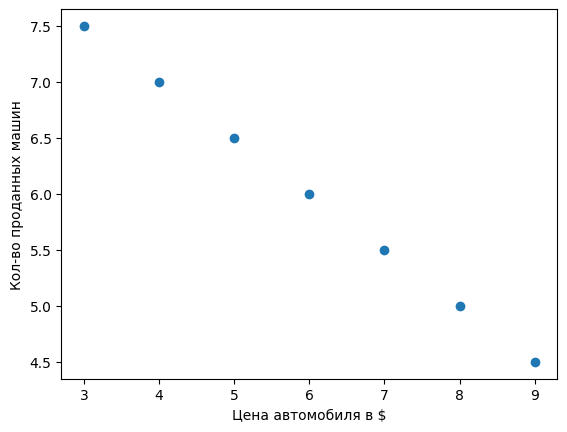

In [ ]:
'''
Например, у нас есть автомобильная компания. Если цена автомобиля низкая, мы продаем больше автомобилей, выше - меньше.
Вопрос в том, каким будет количество проданных автомобилей, если цена автомобиля равна 100.
'''
car_prices_array = [3,4,5,6,7,8,9]
car_price_np = np.array(car_prices_array,dtype=np.float32)
car_price_np = car_price_np.reshape(-1,1)
car_price_tensor = Variable(torch.from_numpy(car_price_np))

number_of_car_sell_array = [ 7.5, 7, 6.5, 6.0, 5.5, 5.0, 4.5]
number_of_car_sell_np = np.array(number_of_car_sell_array,dtype=np.float32)
number_of_car_sell_np = number_of_car_sell_np.reshape(-1,1)
number_of_car_sell_tensor = Variable(torch.from_numpy(number_of_car_sell_np))

# визуализируем данные
import matplotlib.pyplot as plt
plt.scatter(car_prices_array,number_of_car_sell_array)
plt.xlabel("Цена автомобиля в $")
plt.ylabel("Кол-во проданных машин")
plt.show()

epoch 0, loss 12.837849617004395
epoch 50, loss 5.317391872406006
epoch 100, loss 3.593183994293213
epoch 150, loss 2.4280664920806885
epoch 200, loss 1.6407461166381836
epoch 250, loss 1.1087214946746826
epoch 300, loss 0.7492100596427917
epoch 350, loss 0.5062727332115173
epoch 400, loss 0.34210968017578125
epoch 450, loss 0.23117776215076447
epoch 500, loss 0.1562165766954422
epoch 550, loss 0.10556188970804214
epoch 600, loss 0.07133261114358902
epoch 650, loss 0.0482025146484375
epoch 700, loss 0.03257235139608383
epoch 750, loss 0.022010447457432747
epoch 800, loss 0.014873429201543331
epoch 850, loss 0.010050661861896515
epoch 900, loss 0.006791700143367052
epoch 950, loss 0.00458940165117383
epoch 1000, loss 0.003101272275671363


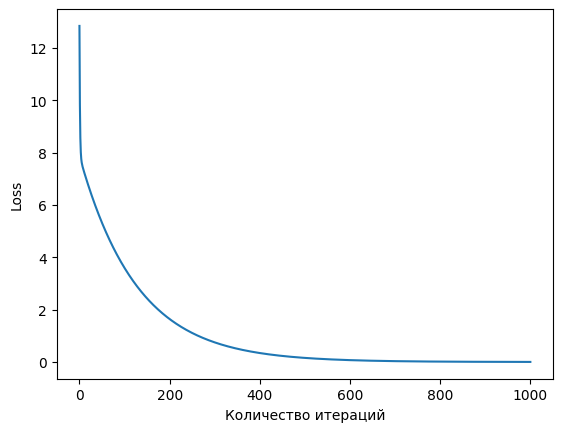

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")

# create class
class LinearRegression(nn.Module):
    def __init__(self,input_size,output_size):
        # super позволяеть наследовать методы модуля nn
        super(LinearRegression,self).__init__()
        # создаем линейный слой
        self.linear = nn.Linear(input_dim,output_dim)

    def forward(self,x):
        return self.linear(x)

# определяем модель
input_dim = 1
output_dim = 1
model = LinearRegression(input_dim,output_dim)

# mse потери
mse = nn.MSELoss()

# скорость спуска
learning_rate = 0.02
optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate) # сразу используем sgd

# обучаем
loss_list = []
iteration_number = 1001
for iteration in range(iteration_number):
    '''
    В PyTorch нам нужно установить градиенты на ноль,
    прежде чем начинать обратное распространение, поскольку PyTorch
    накапливает градиенты при последующих обратных проходах.
    '''
    optimizer.zero_grad()

    # прогнозы
    results = model(car_price_tensor)
    # потери
    loss = mse(results, number_of_car_sell_tensor)
    # вычисляем потери
    loss.backward()
    # делаем шаг
    optimizer.step() # в numpy бы сделали что-то типа param = param - lr * param.grad / batch_size
    # сохраняем loss для визуализации
    loss_list.append(loss.item())
    # отображаем
    if(iteration % 50 == 0):
        print('epoch {}, loss {}'.format(iteration, loss.item()))

plt.plot(range(iteration_number),loss_list)
plt.xlabel("Количество итераций")
plt.ylabel("Loss")
plt.show()

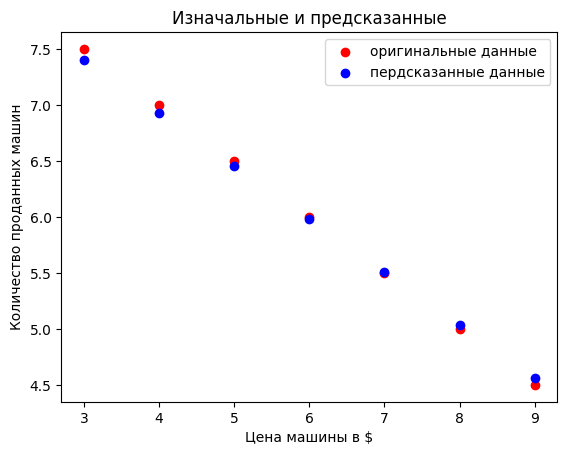

In [ ]:
# предсказываем
predicted = model(car_price_tensor).data.numpy()
plt.scatter(car_prices_array, number_of_car_sell_array, label = "оригинальные данные",color ="red")
plt.scatter(car_prices_array, predicted, label = "пердсказанные данные",color ="blue")

# предсказать количество продаж при цене в 10$
# predicted_10 = model(torch.from_numpy(np.array([10]))).data.numpy()
# отобразить
# plt.scatter(10,predicted_10.data,label = "car price 10$",color ="green")
plt.legend()
plt.xlabel("Цена машины в $")
plt.ylabel("Количество проданных машин")
plt.title("Изначальные и предсказанные")
plt.show()

Еще один пример произвольно заданной функции:

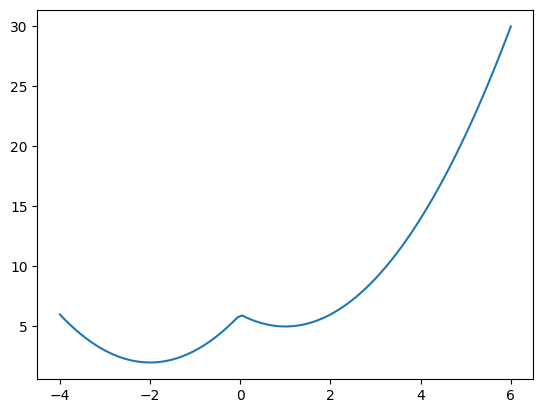

In [ ]:
f = lambda x: (x**2 + 4*x + 6) * (x<0) + (x**2 - 2*x + 6) * (x>0)

x = np.linspace(-4,6, 100)
plt.plot(x, f(x));

Найдем минимум и визуализируем

In [ ]:
# Пускай х - тензор со значением 5
x = torch.tensor(5.0, requires_grad=True)
# Инициализируем оптимизатор sgd
optimizer = torch.optim.SGD(params=[x], lr=0.1)

# Будем записывать изменение значений х
x_history = [x.data.numpy().copy()]

# сделаем 30 шагов
for i in range(30):
    # Производим прямой проход
    loss = f(x)
    # Обнуляем градиент и вычисляем его
    optimizer.zero_grad()
    loss.backward()
    # делаем шаг
    optimizer.step()
    # записываем в память
    x_history.append(x.data.numpy().copy())

x_history = np.array(x_history)
print('x =', x.data.numpy())

x = 1.0049517


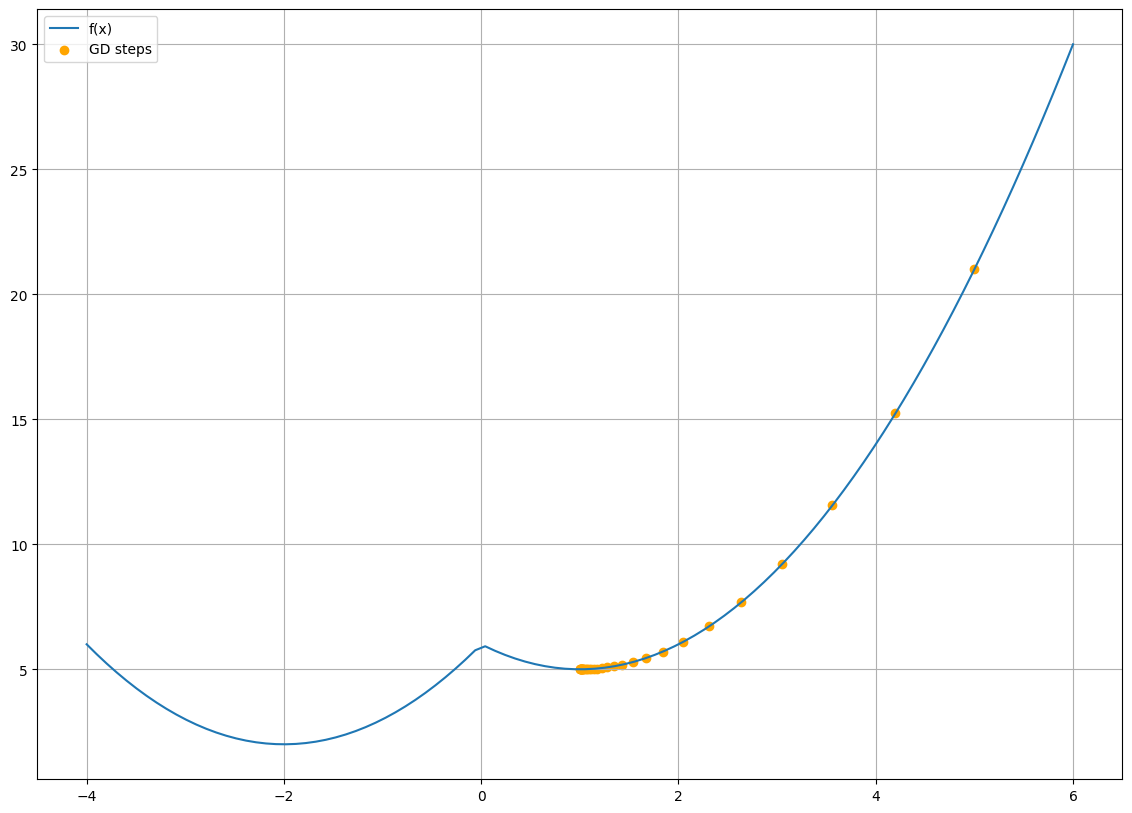

In [ ]:
plt.figure(figsize=(14,10))
x = np.linspace(-4,6, 100)
plt.plot(x, f(x), label='f(x)')
plt.grid()
plt.scatter(x_history, f(x_history), color='orange', label='GD steps')
plt.legend();

Путем итерационного изменения x мы нашли локальный минимум. Как вы видите, мы явно не писали производную от $f (x)$. Но pytorch все равно знает, в каком направлении идти.

Это поможет нам в обучении нейронных сетей. Так что давайте тренировать наши 10 нейронов!

In [ ]:
%%time
# Веса всех нейронов
x0 = np.random.normal(size=(784, 10)) / np.sqrt(784)
neurons = torch.tensor(x0, requires_grad=True)

# Конвертируем датасет в читаемый торчом формат
X = torch.tensor(X_train)
y = torch.tensor(y_train)
# SGD
optimizer = torch.optim.SGD(params=[neurons], lr=1)

loss_history = []

# 100 шагов
for i in range(100):
    # считаем произведение матрицы параметров на матрицу (из 10 нейронов) весов
    predictions = X @ neurons
    # Вычисляем loss
    loss = torch.nn.functional.cross_entropy(predictions, y) # функция активации уже включена
    # Вычисляем градиент
    optimizer.zero_grad()
    loss.backward()
    # Делаем шаг
    optimizer.step()
    # логируем loss
    loss_history.append(loss.data.numpy())

CPU times: user 11.8 s, sys: 87.7 ms, total: 11.9 s
Wall time: 11.9 s


Весь датасет прошли за 15 сек!

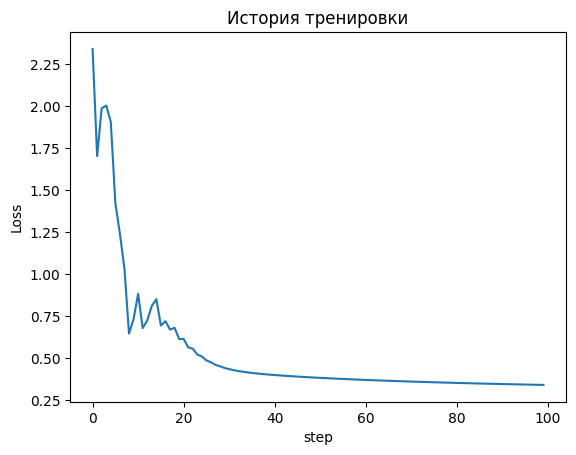

In [ ]:
plt.title('История тренировки')
plt.ylabel('Loss')
plt.xlabel('step')
plt.plot(loss_history);

Посмотрим на нейроны

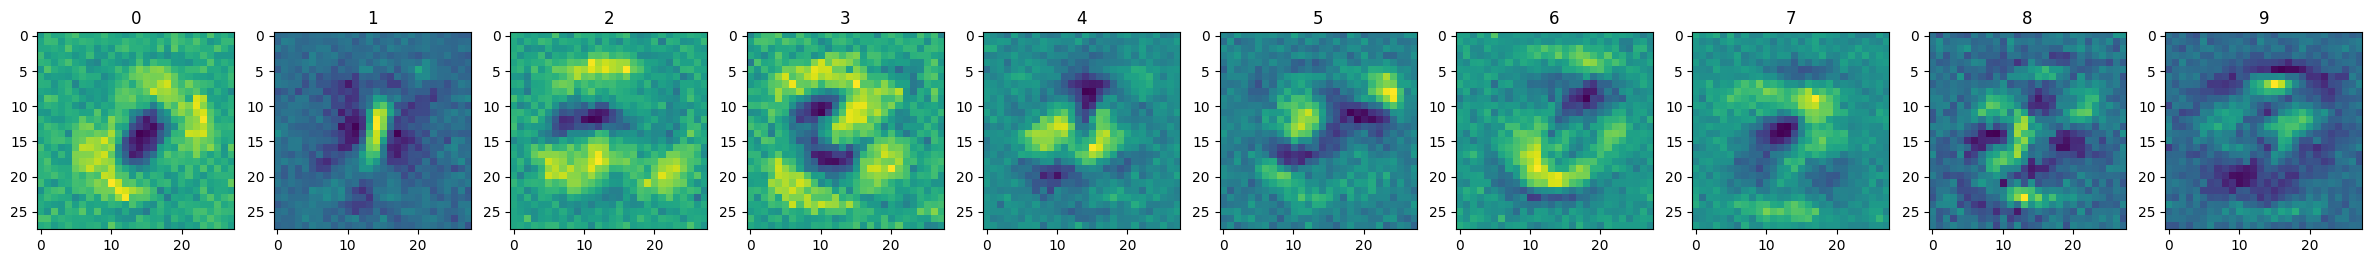

In [ ]:
fig, axes = plt.subplots(1, 10, figsize=(30,30))

for i in range(10):
    axes[i].set_title(i)
    neuron_img = neurons[:,i].data.numpy().reshape(28, 28)
    axes[i].imshow(neuron_img)

Куда больше похоже на цифры по силуэтам!

In [ ]:
# Тот же код для метрик качества

digit_probabilities = sigmoid((X @ neurons).data.numpy())
print('digit_probabilities.shape:', digit_probabilities.shape)
# Находим вероятности на test

# Максимум
predictions = np.argmax(digit_probabilities, axis=1)
print('predictions.shape:', predictions.shape)
print('\nTrain f1:', f1_score(y_train, predictions, average='macro'))

digit_probabilities.shape: (33600, 10)
predictions.shape: (33600,)

Train f1: 0.9035207186663422


Стало 90%! Все из-за кол-ва данных, используем не 500 примеров, а все!

Пример на 10 нейронах

In [ ]:
# Будет использовать высокоуровневый API torch: nn
# Когда мы создаем нейронную сеть в pytorch, мы обычно создаем класс, который происходит от torch.nn.Module
# Это легко обучить и в дальнейшем использовать сеть, определенную таким образом
# Эта сеть имеет 210 нейронов

class MyFirstNN(nn.Module):
    def __init__(self, n_hidden_neurons=200):
        super().__init__()
        # Здесь мы определяем обучаемые параметры модели
        # Первый слой весов
        init_1 = np.random.normal(size=(784, n_hidden_neurons)) / np.sqrt(784) # гуглите "xavier initialization"
        self.neurons_layer1 = torch.tensor(init_1, requires_grad=True) # веса для первого слоя нейронов
        self.neurons_layer1 = nn.Parameter(self.neurons_layer1)

        # веса для второго слоя нейронов
        init_2 = np.random.normal(size=(n_hidden_neurons, 10)) / np.sqrt(n_hidden_neurons)
        self.neurons_layer2 = torch.tensor(init_2, requires_grad=True)
        self.neurons_layer2 = nn.Parameter(self.neurons_layer2)

    def forward(self, x):

        # Здесь мы делаем все вычисления
        # Первый слой
        h = x @ self.neurons_layer1
        # Функция активации скрытого слоя
        h = torch.relu(h)
        # Выходной слой
        out = h @ self.neurons_layer2
        return out

# Люди используют более высокоуровневые функции, такие как nn.Linear, чтобы сделать код короче
# Это простой и явный пример

In [ ]:
import numpy as np

model = MyFirstNN()
# инициализируем Adam для накопления импульса во время спуска
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [ ]:
N_EPOCHS = 100

# Конвертируем в торч тензор
X_tr = torch.tensor(X_train[1000:])
y_tr = torch.tensor(y_train[1000:])
X_dev = torch.tensor(X_train[:1000])
y_dev = torch.tensor(y_train[:1000])

train_loss_history = []
dev_loss_history = []

# Пройдемся 501 эпоху
for i in tqdm(range(N_EPOCHS)):
    # Прямой проход (предсказания)
    predictions = model(X_tr)
    # Функция потерь
    loss = torch.nn.functional.cross_entropy(predictions, y_tr) # активация уже включена
    # Градиенты
    optimizer.zero_grad()
    loss.backward()
    # Шаг спуска
    optimizer.step()
    train_loss_history.append(loss.data.numpy())

    # Валидируемся
    if i % 10 == 0:
        predictions = model(X_dev)
        loss = torch.nn.functional.cross_entropy(predictions, y_dev)
        dev_loss_history.append(loss.data.numpy())

100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


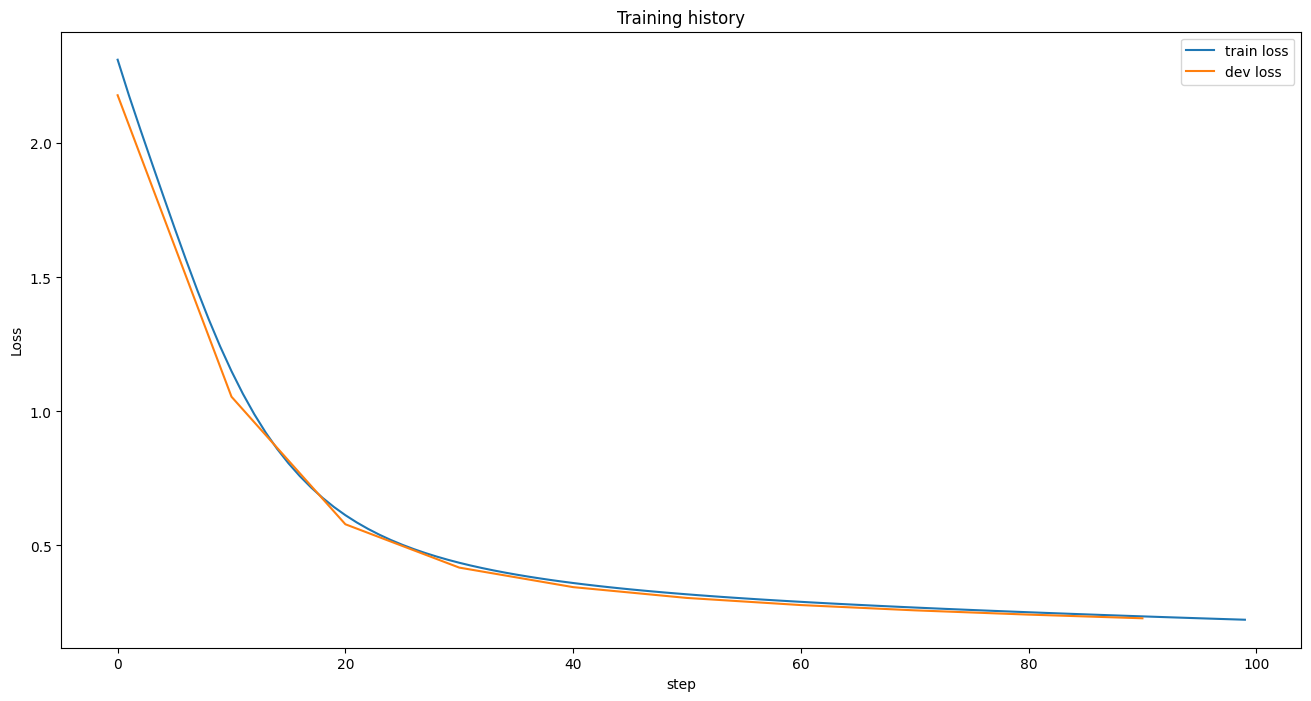

In [ ]:
plt.figure(figsize=(16, 8))
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('step')
plt.plot(range(N_EPOCHS), train_loss_history, label='train loss')
plt.plot(range(N_EPOCHS)[::10], dev_loss_history, label='dev loss')
plt.legend();

In [ ]:
# Метрики качества
digit_probabilities = model(X_dev).data.numpy()
print('digit_probabilities.shape:', digit_probabilities.shape)
# Нашли вероятности принадлежности семплов test-а

# Округлили
predictions = np.argmax(digit_probabilities, axis=1)
print('predictions.shape:', predictions.shape)
print('\Dev accuracy:', accuracy_score(y_train[:1000], predictions))

digit_probabilities.shape: (1000, 10)
predictions.shape: (1000,)
\Dev accuracy: 0.933


In [ ]:
from torch.nn import ReLU
import torch.nn.functional as F

class MySecondNN(nn.Module):
    def __init__(self, n_hidden_neurons=200):
        # super позволяеть наследовать методы модуля nn
        super(MySecondNN,self).__init__()
        # создаем линейный слой
        self.linear1 = nn.Linear(784,256)
        self.linear2 = nn.Linear(256,n_hidden_neurons)
        self.linear3 = nn.Linear(n_hidden_neurons,n_hidden_neurons)
        self.linear4 = nn.Linear(n_hidden_neurons,10)
        self.ReLU = nn.ReLU(inplace=True)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.linear4(x)
        return x

import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = MySecondNN().to(device)
# инициализируем Adam для накопления импульса во время спуска
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [ ]:
next(model.parameters()).is_cuda

True

In [ ]:
X_tr

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
N_EPOCHS = 50

# Конвертируем в торч тензор
X_tr = torch.tensor(X_train[1000:]).float().to(device)
y_tr = torch.tensor(y_train[1000:]).long().to(device)
X_dev = torch.tensor(X_train[:1000]).float().to(device)
y_dev = torch.tensor(y_train[:1000]).long().to(device)

train_loss_history = []
dev_loss_history = []
ce = nn.CrossEntropyLoss()

# Пройдемся 501 эпоху
for i in tqdm(range(N_EPOCHS)):
    # Прямой проход (предсказания)
    predictions = model(X_tr)
    # Функция потерь
    loss = ce(predictions, y_tr) # активация уже включена
    # Градиенты
    optimizer.zero_grad()
    loss.backward()
    # Шаг спуска
    optimizer.step()
    train_loss_history.append(loss.item())

    # Валидируемся
    if i % 10 == 0:
        predictions = model(X_dev)
        loss = ce(predictions, y_dev)
        dev_loss_history.append(loss.item())

100%|██████████| 50/50 [00:00<00:00, 57.54it/s]
